# Feature engineering consumption level

In [83]:
# importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pyarrow
import fastparquet
from sklearn.impute import SimpleImputer

import warnings
warnings.simplefilter('ignore')

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import itertools

# for saving model to disk
import time
from skops.io import dump, load, get_untrusted_types

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (11, 7)

# import data with client ID

In [37]:
date_format_client = {"creation_date": "%d/%m/%Y"}
date_format_invoice = {"invoice_date": "%Y-%m-%d"}

# Import CSVs

client_train = pd.read_csv(
    "data/client_train.csv",
    parse_dates=["creation_date"],
    date_format=date_format_client,
    low_memory=False,
)

invoice_train = pd.read_csv(
    "data/invoice_train.csv",
    parse_dates=["invoice_date"],
    date_format=date_format_invoice,
    low_memory=False,
)

In [38]:
df_train = pd.merge(client_train, invoice_train, how='left', on='client_id')

In [39]:
def data_cleaning(df):

    # First convert 'A' to a number (for example 99) or drop those rows
    df["counter_statue"] = df["counter_statue"].replace("A", 99)

    # Then convert the column to integer type
    df["counter_statue"] = df["counter_statue"].astype(int)

    # Now you can filter as before
    df = df[~(df["counter_statue"] > 5)]

    # drop months number >12
    df = df[df["months_number"] <= 12]

    # drop invoice dates before 2005
    df = df[df["invoice_date"] >= pd.to_datetime("2005-01-01", format="%Y-%m-%d")]

    # drop the counter number, there are a lot of 0 values in both train and test data
    df = df.drop("counter_number", axis=1)

    return df

In [40]:
data_cleaning(df_train)

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,60,train_Client_0,11,101,1994-12-31,0.0,2014-03-24,11,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,60,train_Client_0,11,101,1994-12-31,0.0,2013-03-29,11,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,60,train_Client_0,11,101,1994-12-31,0.0,2015-03-23,11,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,60,train_Client_0,11,101,1994-12-31,0.0,2015-07-13,11,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,60,train_Client_0,11,101,1994-12-31,0.0,2016-11-17,11,0,207,9,1,572,0,0,0,15066,15638,12,ELEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476741,63,train_Client_99997,11,311,2011-11-22,0.0,2014-02-17,40,0,5,9,1,118,0,0,0,406,524,4,GAZ
4476742,63,train_Client_99997,11,311,2011-11-22,0.0,2014-06-13,11,0,207,9,1,312,0,0,0,2562,2874,4,ELEC
4476743,63,train_Client_99997,11,311,2011-11-22,0.0,2019-11-06,11,0,207,9,1,578,0,0,0,8505,9083,4,ELEC
4476744,60,train_Client_99998,11,101,1993-12-22,0.0,2005-08-19,10,0,202,9,1,400,135,0,0,3197,3732,8,ELEC


In [3]:
df_train.columns

Index(['creation_date', 'target', 'counter_coefficient',
       'consommation_level_1', 'consommation_level_2', 'consommation_level_3',
       'consommation_level_4', 'months_number', 'counter_type_ELEC',
       'counter_type_GAZ', 'reading_remarque', 'counter_statue', 'disrict_60',
       'disrict_62', 'disrict_63', 'disrict_69', 'client_catg_11',
       'client_catg_12', 'client_catg_51', 'region_101', 'region_103',
       'region_104', 'region_105', 'region_106', 'region_107', 'region_199',
       'region_206', 'region_301', 'region_302', 'region_303', 'region_304',
       'region_305', 'region_306', 'region_307', 'region_308', 'region_309',
       'region_310', 'region_311', 'region_312', 'region_313', 'region_371',
       'region_372', 'region_379', 'region_399', 'tarif_type_10',
       'tarif_type_11', 'tarif_type_12', 'tarif_type_13', 'tarif_type_14',
       'tarif_type_15', 'tarif_type_18', 'tarif_type_21', 'tarif_type_24',
       'tarif_type_27', 'tarif_type_29', 'tarif_type_4

In [41]:
df_consumption = df_train[['client_id', 'target', 'consommation_level_1', 'consommation_level_2', 'consommation_level_3',
       'consommation_level_4', 'months_number']]

In [42]:
df_consumption_normalized = df_consumption.copy()


In [43]:
df_consumption_normalized = df_consumption_normalized[df_consumption_normalized['months_number'] != 0]

In [44]:
# normalize the data

df_consumption_normalized['consommation_level_1'] = df_consumption_normalized['consommation_level_1'] / df_consumption_normalized['months_number']
df_consumption_normalized['consommation_level_2'] = df_consumption_normalized['consommation_level_2'] / df_consumption_normalized['months_number']
df_consumption_normalized['consommation_level_3'] = df_consumption_normalized['consommation_level_3'] / df_consumption_normalized['months_number']
df_consumption_normalized['consommation_level_4'] = df_consumption_normalized['consommation_level_4'] / df_consumption_normalized['months_number']

In [32]:
corr = df_consumption_normalized.corr()

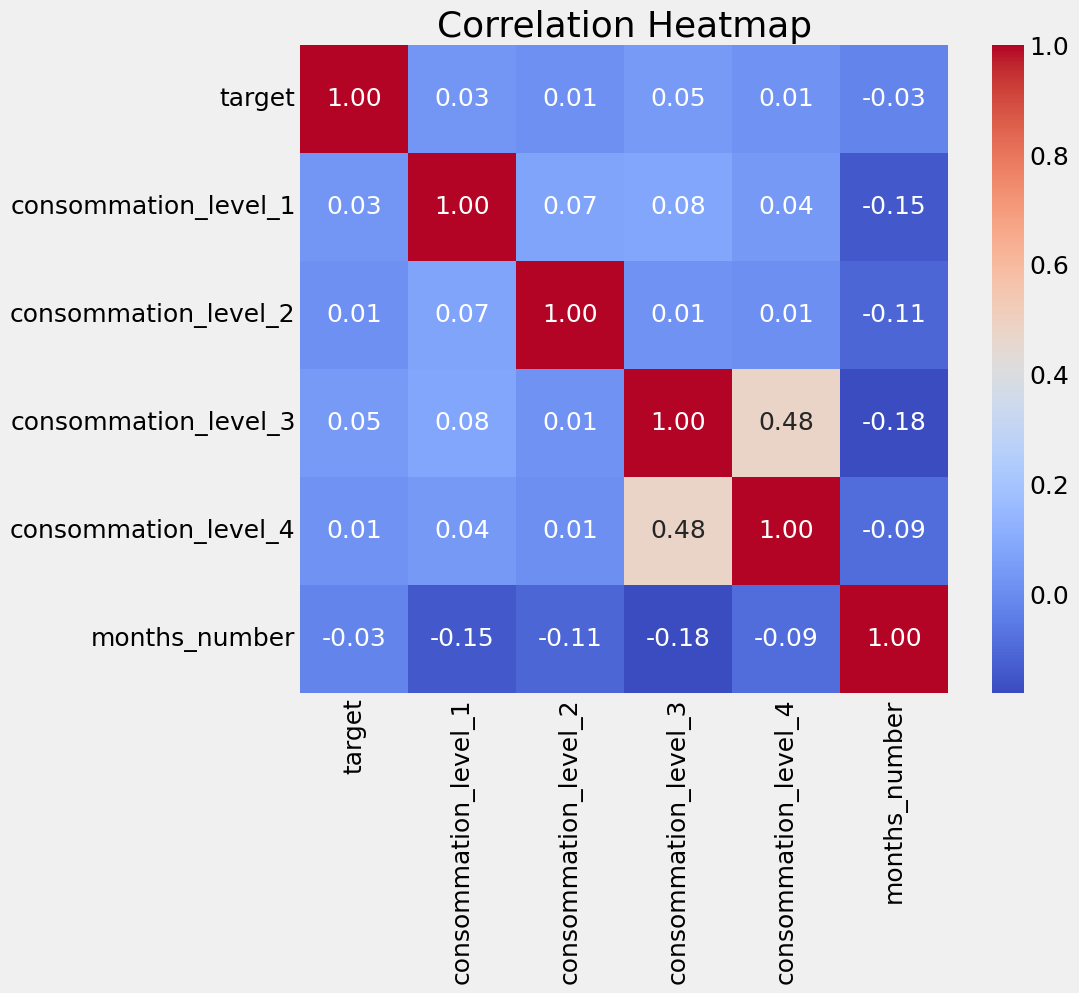

In [33]:
# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.show()

In [65]:
aggcol = ['min', 'max', 'median', 'sum', 'std']

aggregated = df_consumption_normalized.groupby('client_id').agg({
    'consommation_level_1': aggcol,
    'consommation_level_2': aggcol,
    'consommation_level_3': aggcol,
    'consommation_level_4': aggcol,
    'target': 'mean'
})

In [66]:
aggregated.columns = [
    '_'.join(col).strip() if isinstance(col, tuple) else col
    for col in aggregated.columns.values
]
aggregated = aggregated.reset_index()
aggregatednum = aggregated.select_dtypes(include='number')

In [67]:
corr = aggregatednum.corr()

In [110]:
aggregated.columns

Index(['client_id', 'consommation_level_1_min', 'consommation_level_1_max',
       'consommation_level_1_median', 'consommation_level_1_sum',
       'consommation_level_1_std', 'consommation_level_2_min',
       'consommation_level_2_max', 'consommation_level_2_median',
       'consommation_level_2_sum', 'consommation_level_2_std',
       'consommation_level_3_min', 'consommation_level_3_max',
       'consommation_level_3_median', 'consommation_level_3_sum',
       'consommation_level_3_std', 'consommation_level_4_min',
       'consommation_level_4_max', 'consommation_level_4_median',
       'consommation_level_4_sum', 'consommation_level_4_std', 'target_mean'],
      dtype='object')

In [130]:
aggregated.isna().sum()

client_id                         0
consommation_level_1_min          0
consommation_level_1_max          0
consommation_level_1_median       0
consommation_level_1_sum          0
consommation_level_1_std       4212
consommation_level_2_min          0
consommation_level_2_max          0
consommation_level_2_median       0
consommation_level_2_sum          0
consommation_level_2_std       4212
consommation_level_3_min          0
consommation_level_3_max          0
consommation_level_3_median       0
consommation_level_3_sum          0
consommation_level_3_std       4212
consommation_level_4_min          0
consommation_level_4_max          0
consommation_level_4_median       0
consommation_level_4_sum          0
consommation_level_4_std       4212
target_mean                       0
dtype: int64

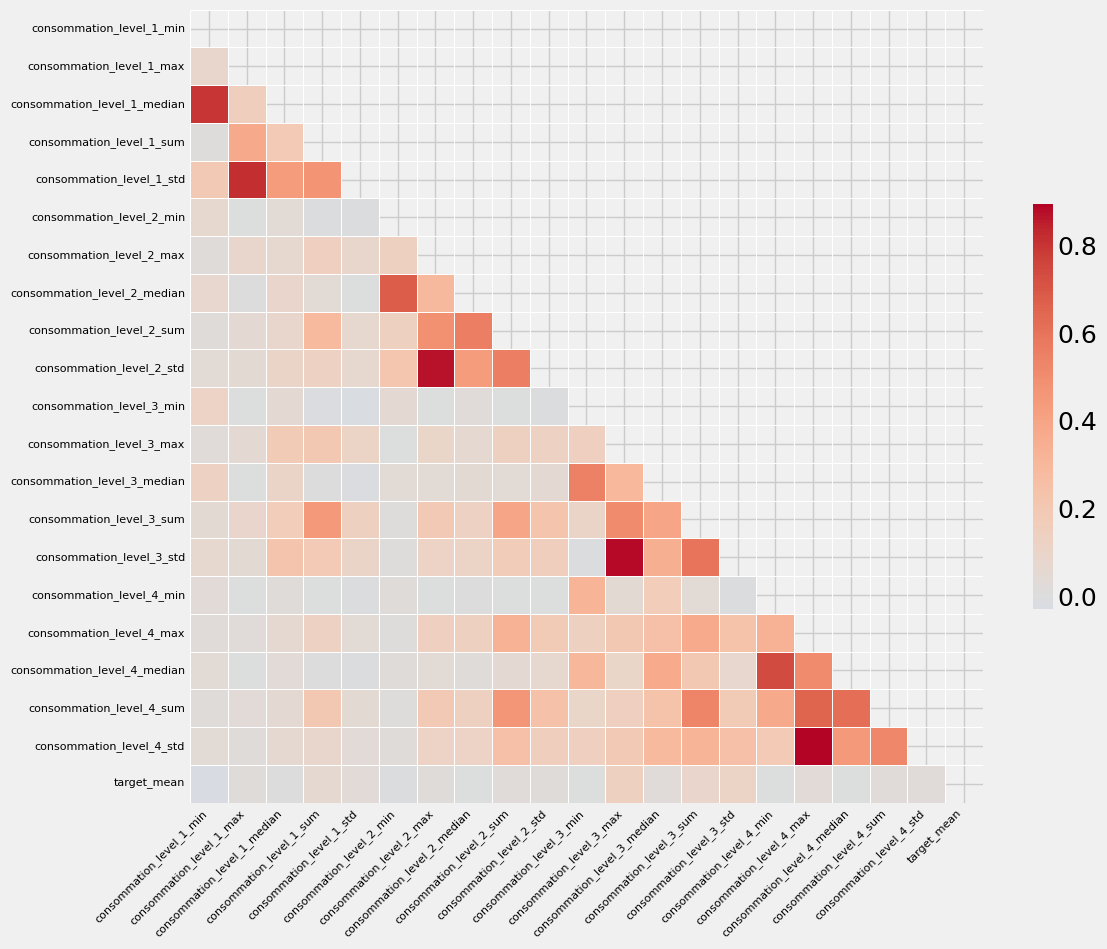

In [68]:
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# Feature: how many entries per consumption level per client?

In [76]:
# Assuming df has 'client_id' and the four level columns
level_cols = ['consommation_level_1', 'consommation_level_2',
              'consommation_level_3', 'consommation_level_4']

# Convert all non-zero values to 1, so we count usage *occurrences*
df_bin = df_train.copy()
df_bin[level_cols] = df_bin[level_cols].gt(0).astype(int)

# Now group by client_id and sum to get counts per level
level_counts = df_bin.groupby('client_id')[level_cols].sum().reset_index()

level_counts.head()

,client_id,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4
0,train_Client_0,35,2,0,0
1,train_Client_1,37,0,0,0
2,train_Client_10,18,1,0,0
3,train_Client_100,4,0,0,0
4,train_Client_1000,14,5,3,2


In [78]:
df_level_counts = pd.concat([level_counts, aggregated.drop(columns='client_id')], axis=1)

In [88]:
df_level_counts = df_level_counts[['consommation_level_1', 'consommation_level_2', 'consommation_level_3','consommation_level_4', 'target_mean']]

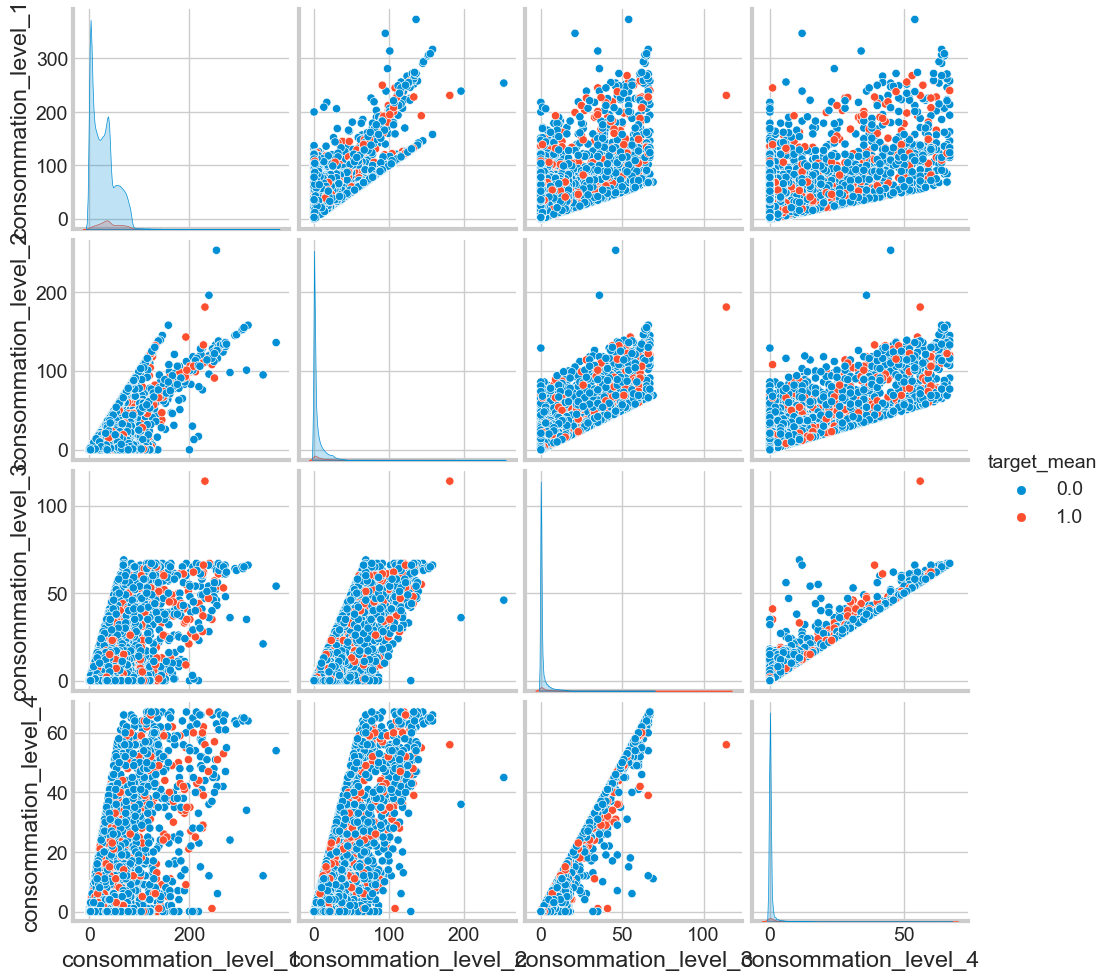

In [84]:
sns.pairplot(df_level_counts, hue='target_mean')

In [85]:
corr2 = df_level_counts.corr()

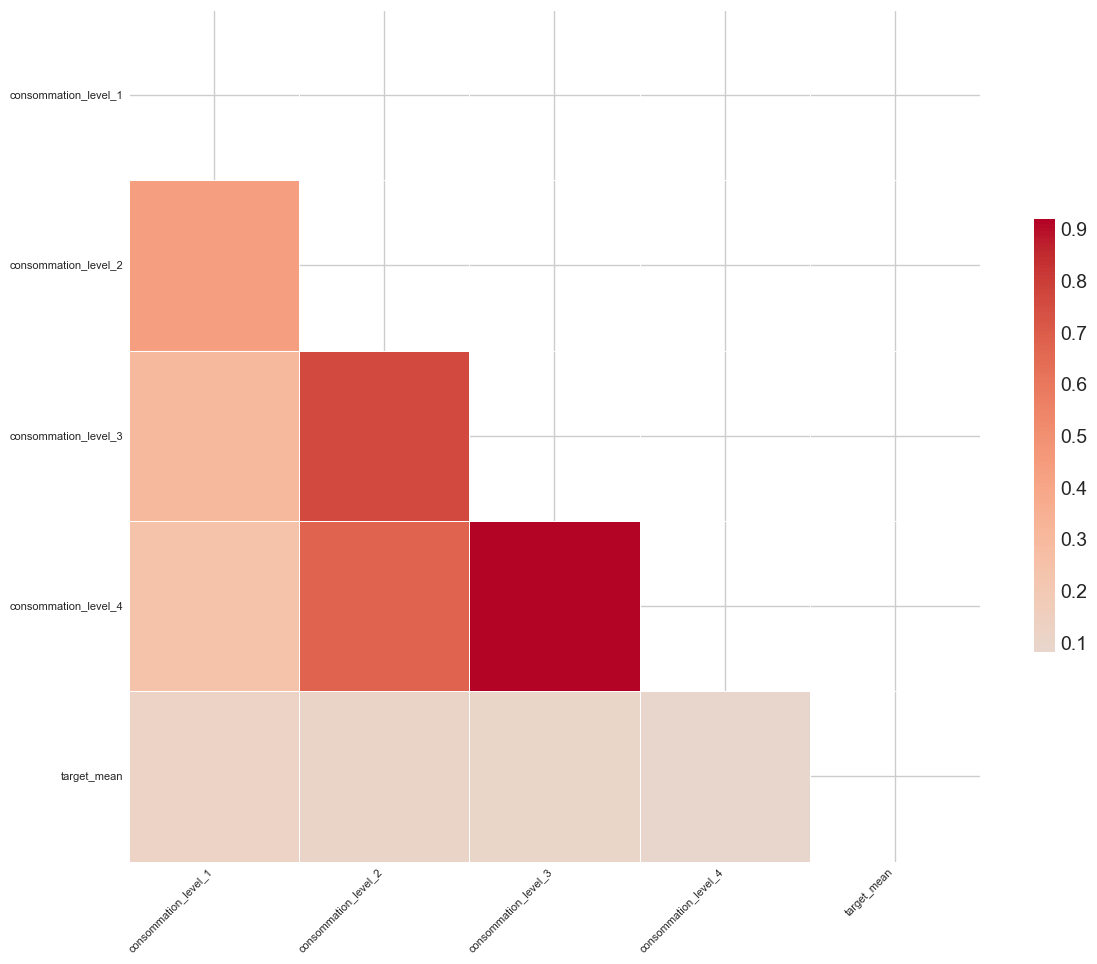

In [87]:
mask = np.triu(np.ones_like(corr2, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr2, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [89]:
df_level_counts_legit = df_level_counts[df_level_counts['target_mean'] == 0.0]
df_level_counts_fraud = df_level_counts[df_level_counts['target_mean'] == 1.0]

# KDE plots in logcale for the number of entries per consumption level

* fraudsters have a high number of entries for consumption level 3

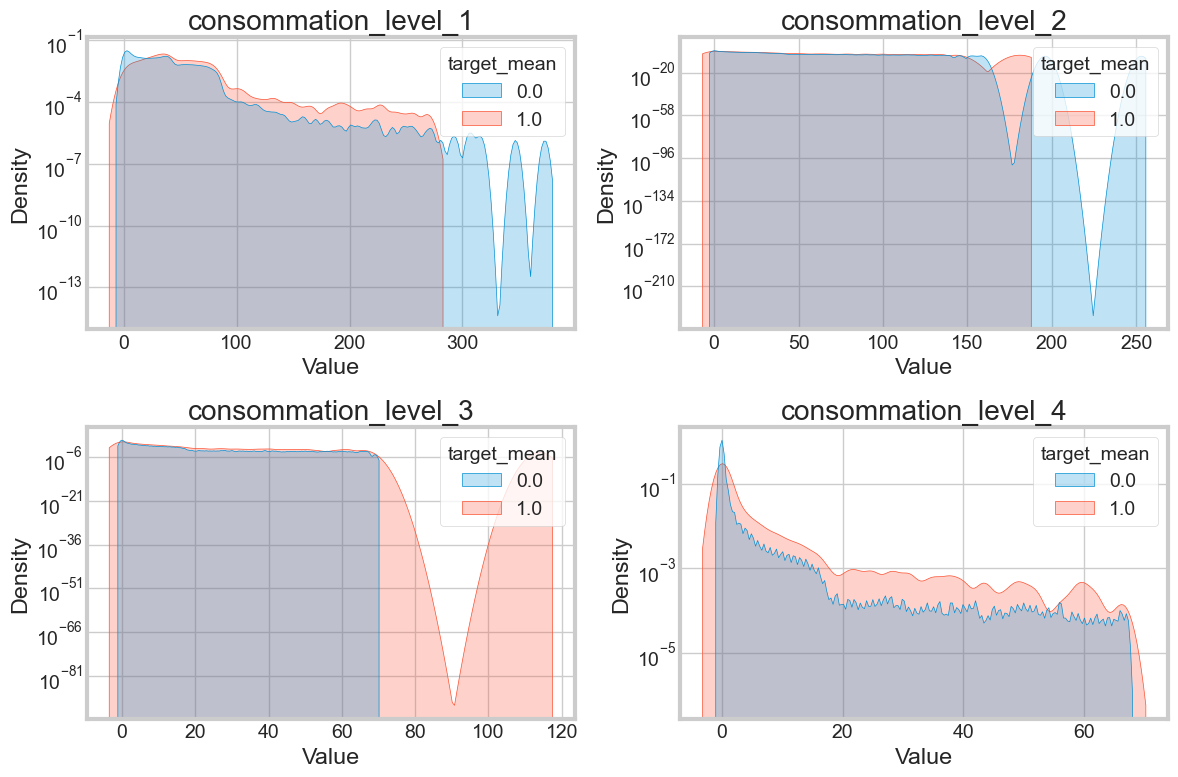

In [106]:
cols = ['consommation_level_1', 'consommation_level_2', 
        'consommation_level_3', 'consommation_level_4']


fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid
axes = axes.flatten()  # to iterate easily

for i, col in enumerate(cols):
    sns.kdeplot(data=df_level_counts, x=col, ax=axes[i], fill=True, common_norm=False, hue='target_mean')
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Density")
    axes[i].set_yscale('log')

plt.tight_layout()
plt.show()

# KDE plots for the STDEV

* fraudsters are in the low range of level 2 stdev

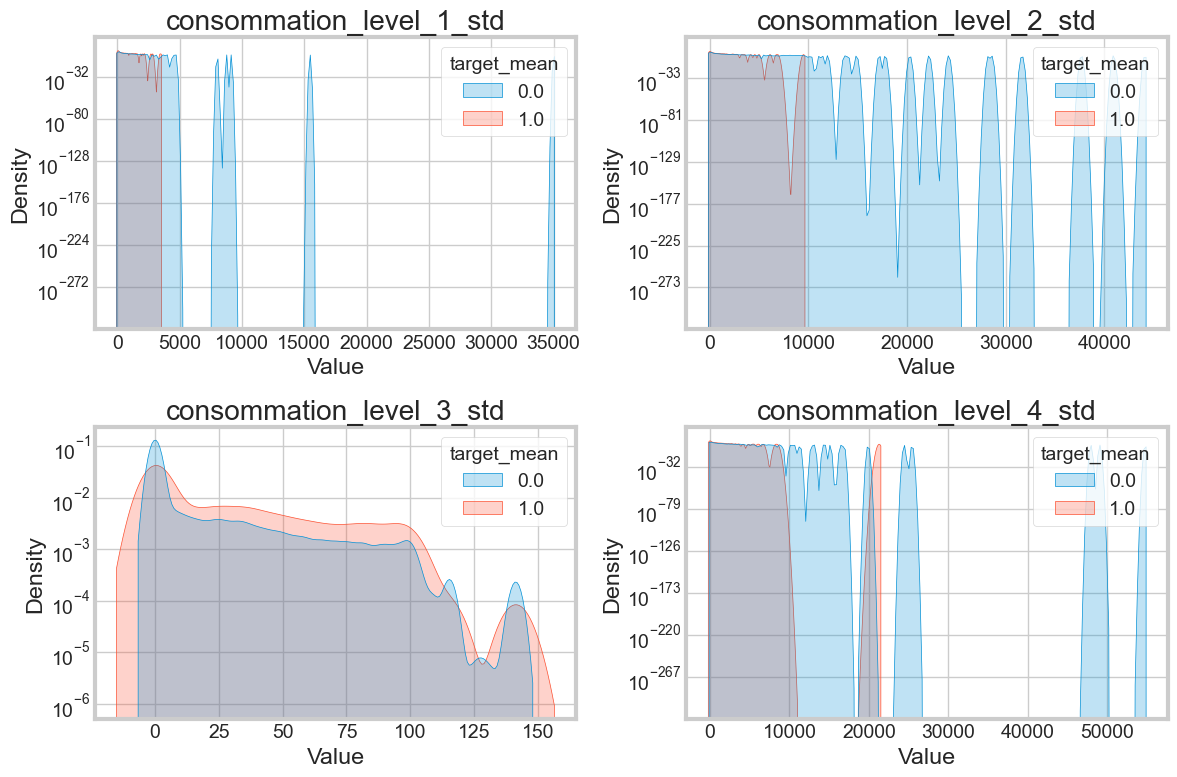

In [105]:
cols_std = ['consommation_level_1_std', 'consommation_level_2_std', 
        'consommation_level_3_std', 'consommation_level_4_std']


fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid
axes = axes.flatten()  # to iterate easily

for i, col in enumerate(cols_std):
    sns.kdeplot(data=aggregated, x=col, ax=axes[i], fill=True, common_norm=False, hue='target_mean')
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Density")
    axes[i].set_yscale('log')

plt.tight_layout()
plt.show()

# KDE plots for maximum

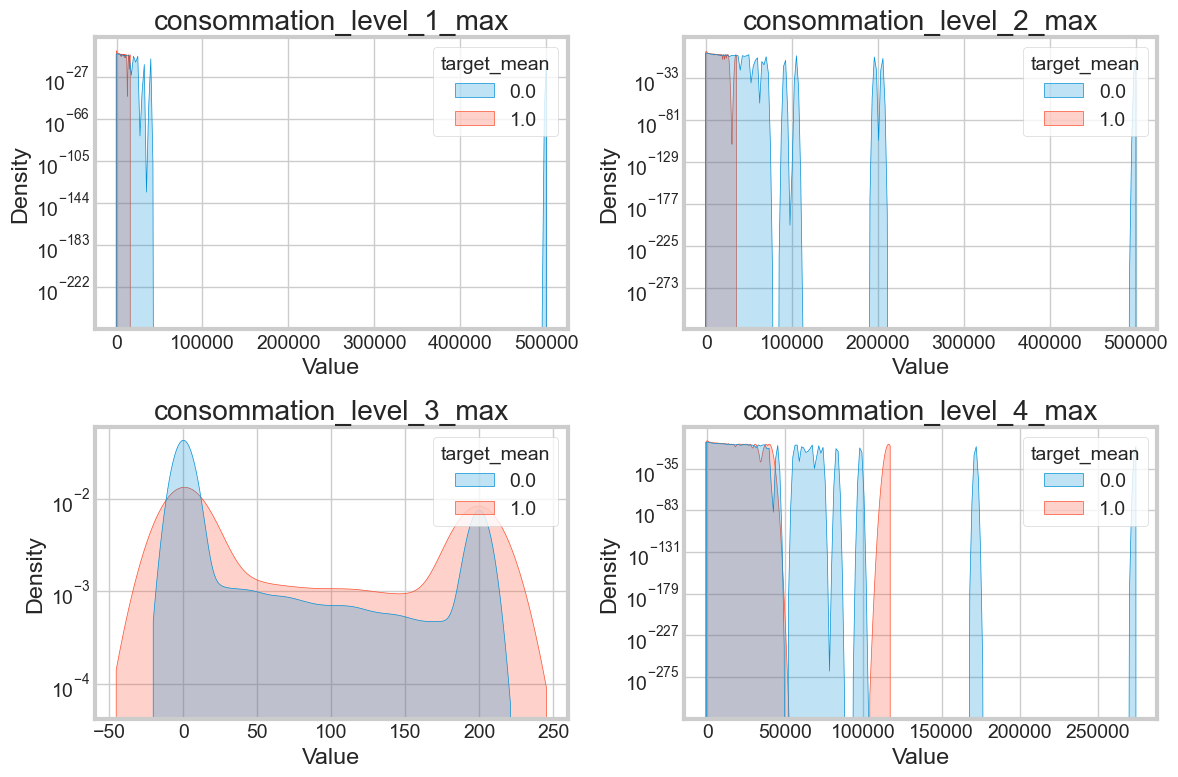

In [107]:
cols_max = ['consommation_level_1_max', 'consommation_level_2_max', 
        'consommation_level_3_max', 'consommation_level_4_max']


fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid
axes = axes.flatten()  # to iterate easily

for i, col in enumerate(cols_max):
    sns.kdeplot(data=aggregated, x=col, ax=axes[i], fill=True, common_norm=False, hue='target_mean')
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Density")
    axes[i].set_yscale('log')

plt.tight_layout()
plt.show()

# KDE plots for minimum

* fraudsters are in the low range for level 1, 2, and 4 minimum

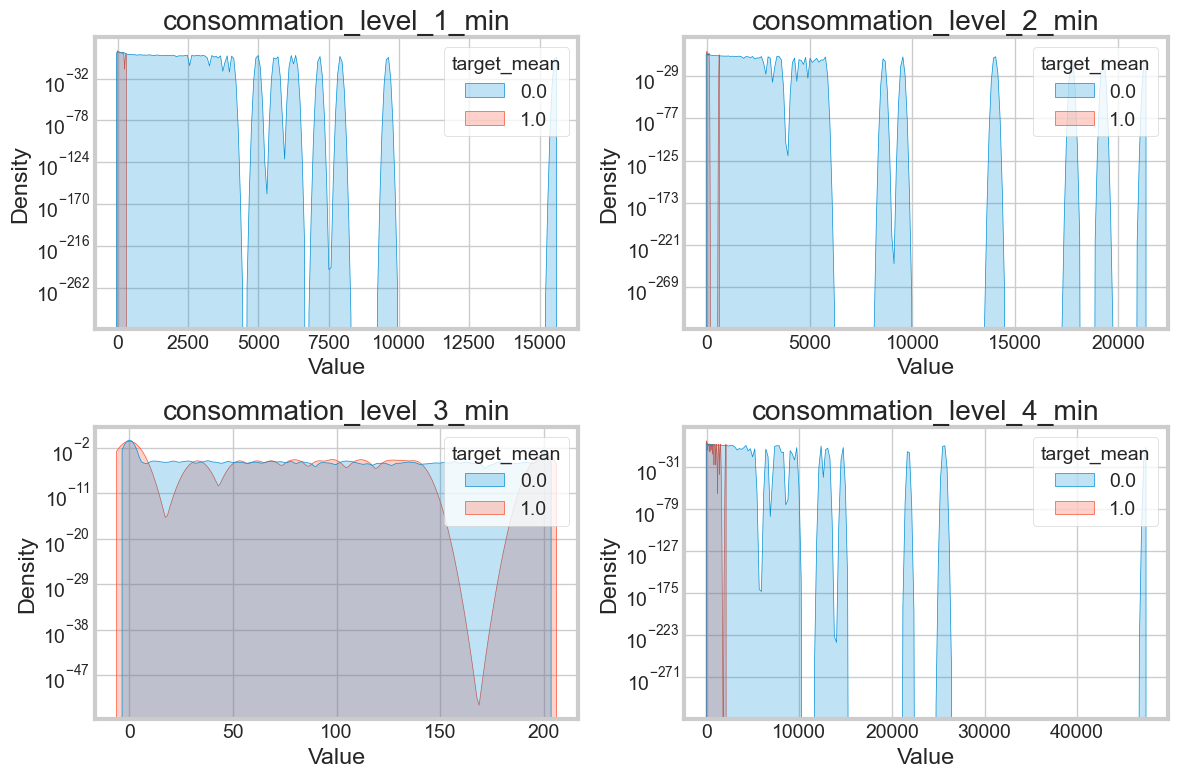

In [108]:
cols_min = ['consommation_level_1_min', 'consommation_level_2_min', 
        'consommation_level_3_min', 'consommation_level_4_min']


fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid
axes = axes.flatten()  # to iterate easily

for i, col in enumerate(cols_min):
    sns.kdeplot(data=aggregated, x=col, ax=axes[i], fill=True, common_norm=False, hue='target_mean')
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Density")
    axes[i].set_yscale('log')

plt.tight_layout()
plt.show()

# KDE median

* fraudsters are in the low range of level 1, 2 and 4 median

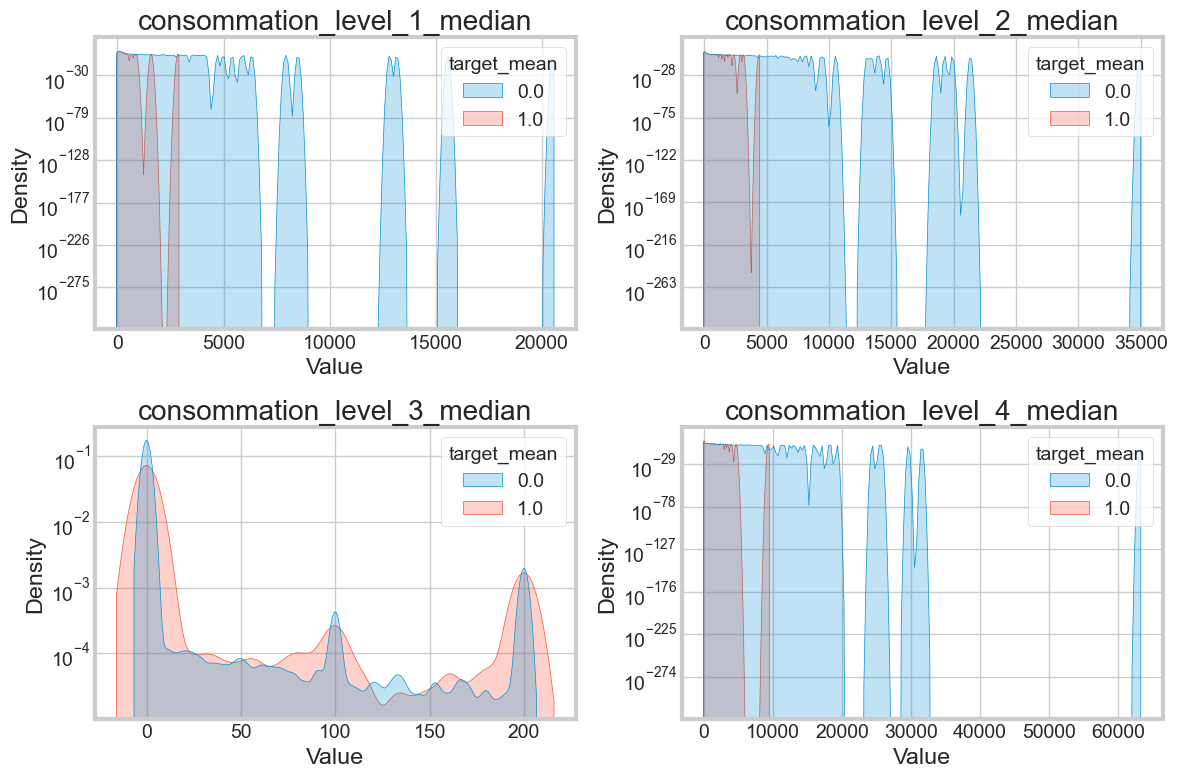

In [109]:
cols_median = ['consommation_level_1_median', 'consommation_level_2_median', 
        'consommation_level_3_median', 'consommation_level_4_median']


fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid
axes = axes.flatten()  # to iterate easily

for i, col in enumerate(cols_median):
    sns.kdeplot(data=aggregated, x=col, ax=axes[i], fill=True, common_norm=False, hue='target_mean')
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Density")
    axes[i].set_yscale('log')

plt.tight_layout()
plt.show()

# Summary

I will make a dataframe with these columns

* fraudsters have a high number of entries for consumption level 3
* fraudsters are in the low range of level 2 stdev
* fraudsters are in the low range of level 1, 2 and 4 minimum
* fraudsters are in the low range of level 1, 2 and 4 median

# start here again for model

In [398]:
aggregated.columns

Index(['client_id', 'consommation_level_1_min', 'consommation_level_1_max',
       'consommation_level_1_median', 'consommation_level_1_sum',
       'consommation_level_1_std', 'consommation_level_2_min',
       'consommation_level_2_max', 'consommation_level_2_median',
       'consommation_level_2_sum', 'consommation_level_2_std',
       'consommation_level_3_min', 'consommation_level_3_max',
       'consommation_level_3_median', 'consommation_level_3_sum',
       'consommation_level_3_std', 'consommation_level_4_min',
       'consommation_level_4_max', 'consommation_level_4_median',
       'consommation_level_4_sum', 'consommation_level_4_std', 'target_mean'],
      dtype='object')

In [399]:

# New DataFrame with selected columns
df_frankenstein = pd.DataFrame({
    'client_id': aggregated['client_id'],
    'entries_level_3': df_level_counts['consommation_level_3'],
    'level_2_std': aggregated['consommation_level_2_std'],
    'level_1_min': aggregated['consommation_level_1_min'],
    'level_2_min': aggregated['consommation_level_2_min'],
    'level_4_min': aggregated['consommation_level_4_min'],
    # 'level_1_median': aggregated['consommation_level_1_median'],
    # 'level_2_median': aggregated['consommation_level_2_median'],
    # 'level_4_median': aggregated['consommation_level_4_median'], # too high correlation with min
    'target': aggregated['target_mean']
}).reset_index(drop=True)

In [400]:
df_frankenstein.isna().sum()

client_id             0
entries_level_3       0
level_2_std        4212
level_1_min           0
level_2_min           0
level_4_min           0
target                0
dtype: int64

In [401]:
# fill the NaNs in the standard deviation column
df_frankenstein['level_2_std'] = df_frankenstein['level_2_std'].fillna(0)

In [402]:
from broken_meter_function import broken_meter_function

broken_meter_function(df_train)

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,meter_broken
0,60,train_Client_0,11,101,1994-12-31,0.0,2014-03-24,11,1335667,0,...,1,82,0,0,0,14302,14384,4,ELEC,0
1,60,train_Client_0,11,101,1994-12-31,0.0,2013-03-29,11,1335667,0,...,1,1200,184,0,0,12294,13678,4,ELEC,0
2,60,train_Client_0,11,101,1994-12-31,0.0,2015-03-23,11,1335667,0,...,1,123,0,0,0,14624,14747,4,ELEC,0
3,60,train_Client_0,11,101,1994-12-31,0.0,2015-07-13,11,1335667,0,...,1,102,0,0,0,14747,14849,4,ELEC,0
4,60,train_Client_0,11,101,1994-12-31,0.0,2016-11-17,11,1335667,0,...,1,572,0,0,0,15066,15638,12,ELEC,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476744,60,train_Client_99998,11,101,1993-12-22,0.0,2005-08-19,10,1253571,0,...,1,400,135,0,0,3197,3732,8,ELEC,0
4476745,60,train_Client_99998,11,101,1993-12-22,0.0,2005-12-19,10,1253571,0,...,1,200,6,0,0,3732,3938,4,ELEC,0
4476746,60,train_Client_99999,11,101,1986-02-18,0.0,1996-09-25,11,560948,0,...,1,259,0,0,0,13884,14143,4,ELEC,0
4476747,60,train_Client_99999,11,101,1986-02-18,0.0,1996-05-28,11,560948,0,...,1,603,0,0,0,13281,13884,4,ELEC,0


In [403]:
broken_meter = df_train.groupby('client_id')['meter_broken'].mean().reset_index()

In [404]:
df_frankenstein = pd.concat([df_frankenstein, broken_meter['meter_broken']], axis=1)

In [405]:
df_frankenstein.to_parquet('df_frankenstein.parquet')

In [356]:
corr_frankenstein = df_frankenstein.corr()

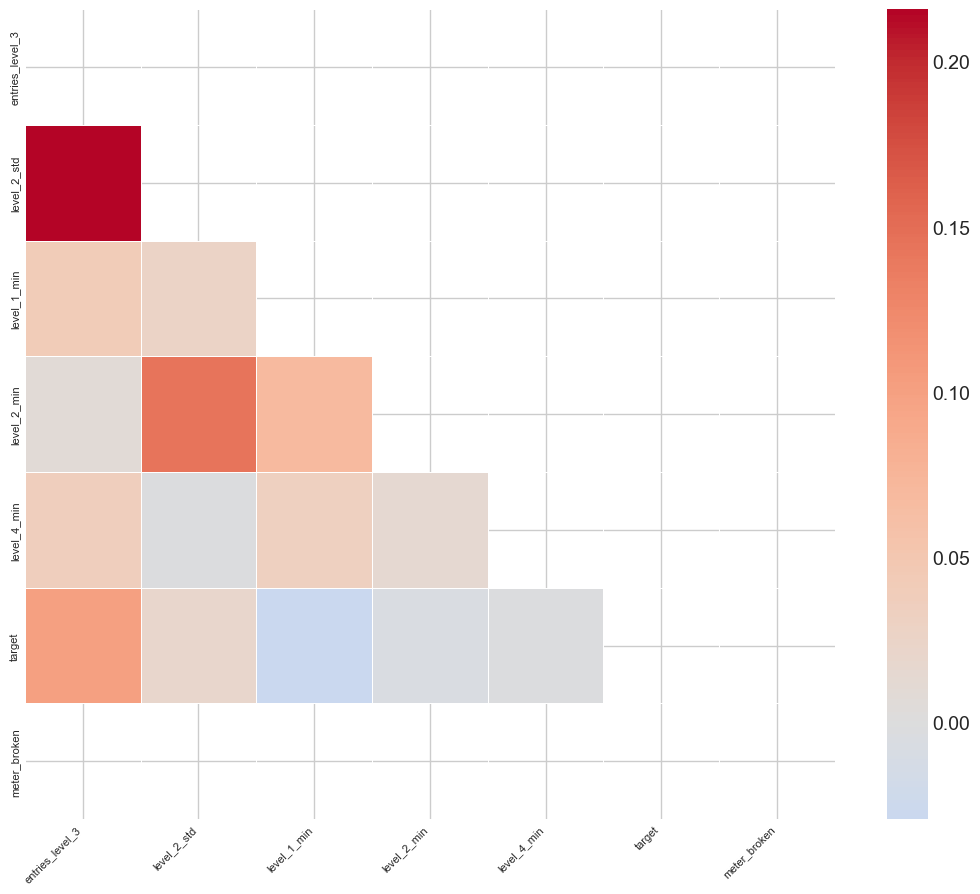

In [362]:
mask = np.triu(np.ones_like(corr_frankenstein, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr_frankenstein, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

# Logistic regression on our reduced dataframe

In [347]:
import pandas as pd
import numpy as np

import pyarrow
import fastparquet

from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt

#from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report, accuracy_score, recall_score, precision_score, roc_auc_score

# for saving model to disk
import time
from skops.io import dump, load, get_untrusted_types

In [363]:
X=df_frankenstein.copy()

In [364]:
y = X.pop("target")

RSEED = 42

# 20% examples in test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=RSEED
)

In [365]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(108394, 6)
(27099, 6)
(108394,)
(27099,)


In [366]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# simple test without parameter tuning

In [174]:
from sklearn.linear_model import LogisticRegression

Accuracy on train set: 0.94
Accuracy on test set: 0.94
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     25586
         1.0       0.11      0.00      0.00      1513

    accuracy                           0.94     27099
   macro avg       0.53      0.50      0.49     27099
weighted avg       0.90      0.94      0.92     27099

--------------------------------------------------------------------------------


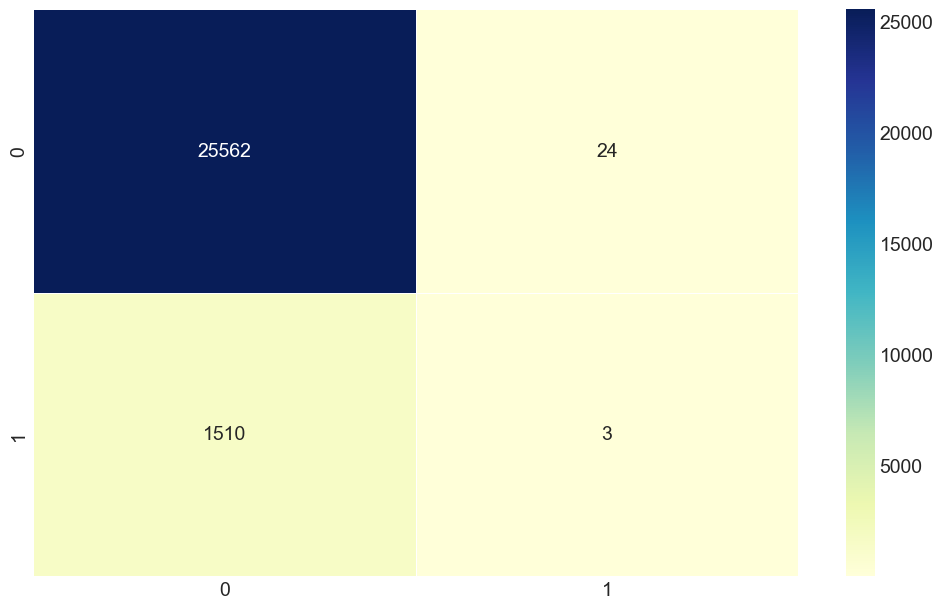

In [367]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_train = log_reg.predict(X_train)
y_pred = log_reg.predict(X_test)

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

In [368]:
f1_train =f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred)

print('Train f1 score =', f1_train)
print('Test f1 score =', f1_test)

Train f1 score = 0.009036630627723093
Test f1 score = 0.003896103896103896


# Test with balancing data

In [369]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train,y_train)

Accuracy on train set: 0.62
Accuracy on test set: 0.77
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.79      0.87     25586
         1.0       0.12      0.46      0.18      1513

    accuracy                           0.77     27099
   macro avg       0.54      0.63      0.53     27099
weighted avg       0.91      0.77      0.83     27099

--------------------------------------------------------------------------------


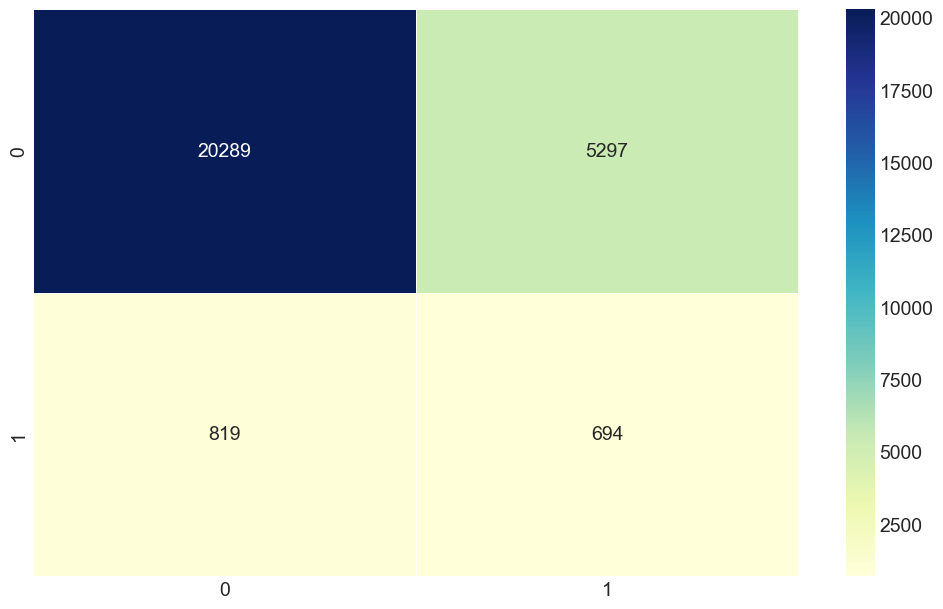

In [370]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_resampled, y_train_resampled)

y_pred_train = log_reg.predict(X_train_resampled)
y_pred = log_reg.predict(X_test)

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train_resampled, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

In [371]:
f1_train =f1_score(y_train_resampled, y_pred_train)
f1_test = f1_score(y_test, y_pred)

print('Train f1 score =', f1_train)
print('Test f1 score =', f1_test)

Train f1 score = 0.5486963953311401
Test f1 score = 0.1849680170575693


# Model with balancing data and hyperparameter tuning

In [372]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],  # types of regularization
    'C': np.logspace(-4, 4, 20),                 # inverse regularization strength
    'solver': ['liblinear', 'saga'],             # solvers that support l1 and elasticnet
    'l1_ratio': np.linspace(0, 1, 10),            # only used if penalty is 'elasticnet'
    'max_iter': [100, 200, 500]
}

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
randomsearch = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_grid,
    n_iter=50,
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1
)

randomsearch.fit(X_train_resampled, y_train_resampled)

/Users/laurabrylka/Documents/Git/ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/laurabrylka/Documents/Git/ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/laurabrylka/Documents/Git/ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/laurabrylka/Documents/Git/ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/laurabrylka/Documents/Git/ds-fraud-detection/.ven

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'l1_ratio': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'max_iter': [100, 200, 500],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    None],
                                        'solver': ['liblinear', 'saga']},
                   random_state=42, scoring='f1')

In [374]:
randomlr_model = randomsearch.best_estimator_

In [377]:
import joblib
joblib.dump(randomlr_model, 'logreg_after_random_search_frankenstein.joblib')

['logreg_after_random_search_frankenstein.joblib']

In [375]:
y_train_pred_rlr = randomlr_model.predict(X_train_resampled)
y_train_probs__rlr = randomlr_model.predict_proba(X_train_resampled)[:, 1]

y_test_pred__rlr = randomlr_model.predict(X_test)
y_test_probs__rlr = randomlr_model.predict_proba(X_test)[:, 1]

Accuracy on train set: 0.63
Accuracy on test set: 0.75
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.77      0.85     25586
         1.0       0.11      0.49      0.18      1513

    accuracy                           0.75     27099
   macro avg       0.54      0.63      0.52     27099
weighted avg       0.91      0.75      0.82     27099

--------------------------------------------------------------------------------


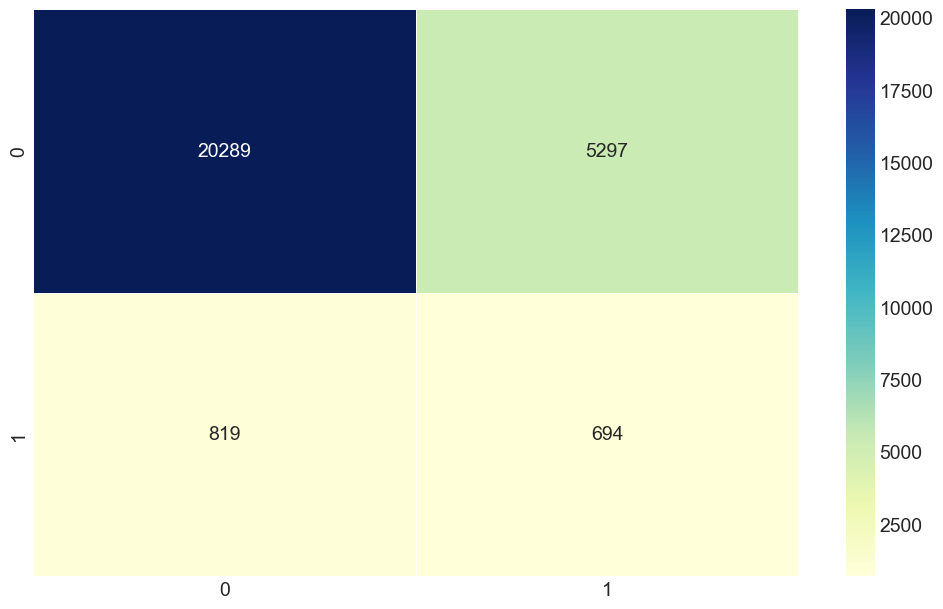

In [376]:
# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train_resampled, y_train_pred_rlr), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_test_pred__rlr), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_test_pred__rlr))
print("--------"*10)



# Evaluate the model with a confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred__rlr)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

In [378]:
f1_train =f1_score(y_train_resampled, y_train_pred_rlr)
f1_test = f1_score(y_test, y_test_pred__rlr)

print('Train f1 score =', f1_train)
print('Test f1 score =', f1_test)

Train f1 score = 0.5684668891025279
Test f1 score = 0.1802439024390244


In [379]:
print("Best parameters:", randomsearch.best_params_)

Best parameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 200, 'l1_ratio': 0.2222222222222222, 'C': 0.00026366508987303583}


Best parameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 200, 'l1_ratio': 0.2222222222222222, 'C': 0.00026366508987303583}

# Gridsearch

In [380]:
param_grid = {
    'penalty': ['l1'],  # 'l1' was best
    'solver': ['liblinear'],  # 'liblinear' supports l1
    'C': [2e-4, 2.5e-4, 3e-4, 3.5e-4],  # Narrowed around 0.00026
    'max_iter': [150, 200, 250],  # Around your best value
}

from sklearn.model_selection import GridSearchCV


lr = LogisticRegression()
gridsearch = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

gridsearch.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.0002, 0.00025, 0.0003, 0.00035],
                         'max_iter': [150, 200, 250], 'penalty': ['l1'],
                         'solver': ['liblinear']},
             scoring='f1')

In [381]:
gridlr_model = gridsearch.best_estimator_

In [382]:
joblib.dump(gridlr_model, 'logreg_after_grid_search_frankenstein.joblib')

['logreg_after_grid_search_frankenstein.joblib']

In [383]:
y_train_pred_glr = gridlr_model.predict(X_train_resampled)
y_train_probs__glr = gridlr_model.predict_proba(X_train_resampled)[:, 1]

y_test_pred__glr = gridlr_model.predict(X_test)
y_test_probs__glr = gridlr_model.predict_proba(X_test)[:, 1]

Accuracy on train set: 0.63
Accuracy on test set: 0.76
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.77      0.86     25586
         1.0       0.11      0.49      0.18      1513

    accuracy                           0.76     27099
   macro avg       0.54      0.63      0.52     27099
weighted avg       0.91      0.76      0.82     27099

--------------------------------------------------------------------------------


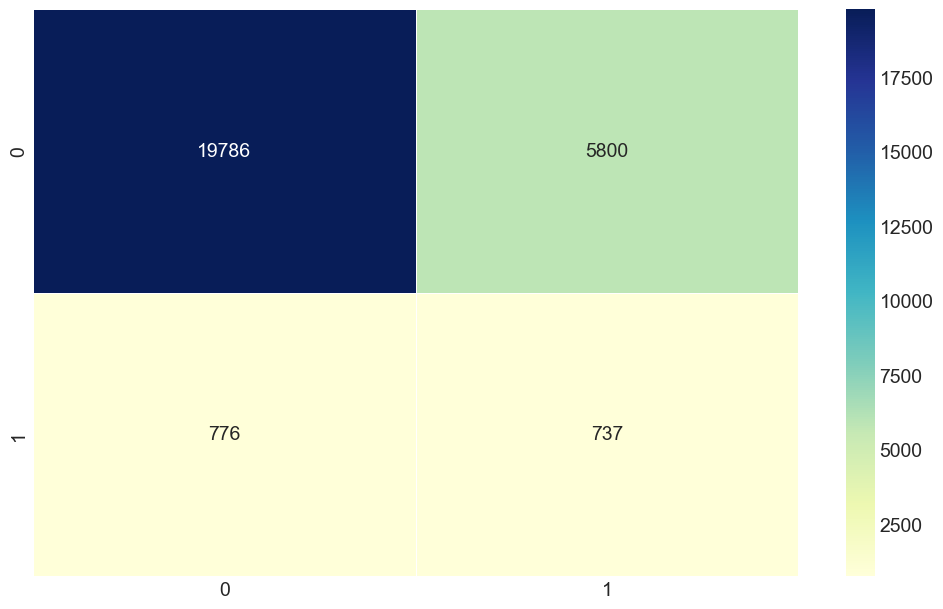

In [384]:
# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train_resampled, y_train_pred_glr), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_test_pred__glr), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_test_pred__glr))
print("--------"*10)



# Evaluate the model with a confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred__glr)
sns.heatmap(cm_test, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

In [385]:
f1_train =f1_score(y_train_resampled, y_train_pred_glr)
f1_test = f1_score(y_test, y_test_pred__glr)

print('Train f1 score =', f1_train)
print('Test f1 score =', f1_test)

Train f1 score = 0.5637071802095154
Test f1 score = 0.1831055900621118


Accuracy on train set: 0.63
Accuracy on test set: 0.76
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.77      0.86     25586
         1.0       0.11      0.49      0.18      1513

    accuracy                           0.76     27099
   macro avg       0.54      0.63      0.52     27099
weighted avg       0.91      0.76      0.82     27099

--------------------------------------------------------------------------------


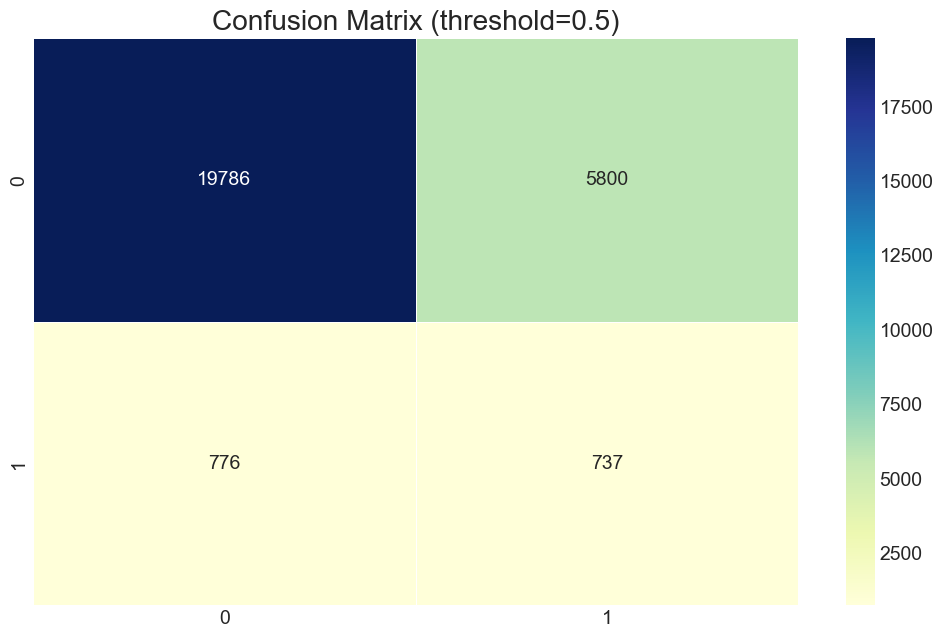

In [386]:
threshold = 0.5  # Example: 0.3 instead of the default 0.5

# Step 3: Apply the threshold
y_pred_threshold = (y_test_probs__glr >= threshold).astype(int)
y_train_pred_threshold = (y_train_probs__glr >= threshold).astype(int)

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train_resampled, y_train_pred_threshold), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_threshold), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred_threshold))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm_test = confusion_matrix(y_test, y_pred_threshold)
sns.heatmap(cm_test, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5)
plt.title(f'Confusion Matrix (threshold={threshold})')
plt.show()

# Try random forest

In [243]:
from sklearn.ensemble import RandomForestClassifier

In [387]:
# with unbalanced data
# Create the model with 100 trees
rndomfrst = RandomForestClassifier(
                               class_weight="balanced",
                               n_estimators=100, 
                               random_state=42, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 5,
                               max_depth = 10,
                               min_samples_leaf = 50,
                               )

# Fit on training data
rndomfrst.fit(X_train, y_train)


n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in rndomfrst.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Training predictions (to demonstrate overfitting)
train_rf_y_predictions = rndomfrst.predict(X_train)
train_rf_y_probs = rndomfrst.predict_proba(X_train)[:, 1]

# Testing predictions (to determine performance)
rf_y_predictions = rndomfrst.predict(X_test)
rf_y_probs = rndomfrst .predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s


building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
Average number of nodes 210
Average maximum depth 10


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 ta

Accuracy on train set: 0.63
Accuracy on test set: 0.63
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.63      0.76     25586
         1.0       0.10      0.67      0.17      1513

    accuracy                           0.63     27099
   macro avg       0.53      0.65      0.46     27099
weighted avg       0.92      0.63      0.73     27099

--------------------------------------------------------------------------------


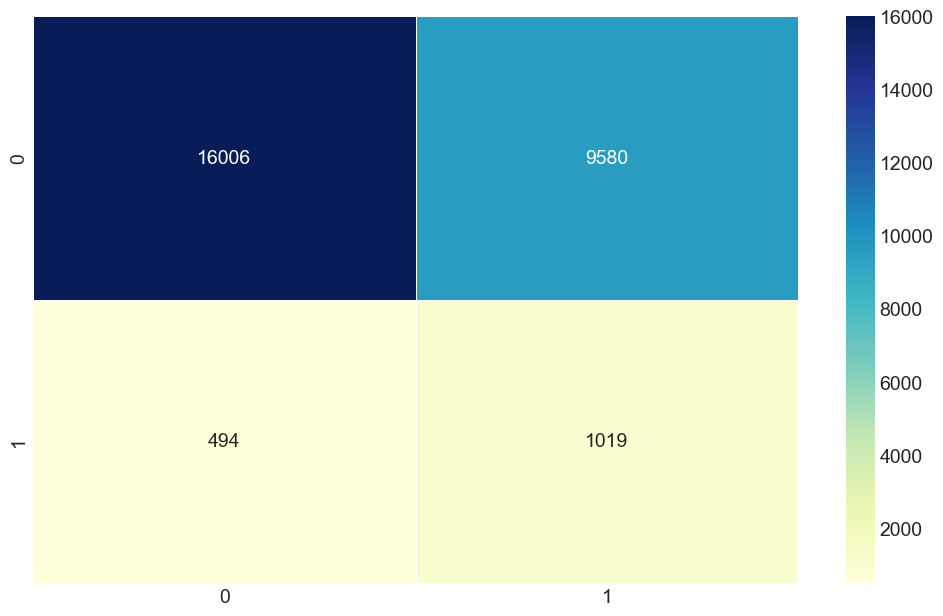

In [388]:
# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, train_rf_y_predictions), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, rf_y_predictions), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, rf_y_predictions))
print("--------"*10)



# Evaluate the model with a confusion matrix
cm_test = confusion_matrix(y_test, rf_y_predictions)
sns.heatmap(cm_test, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

In [389]:
f1_train =f1_score(y_train, train_rf_y_predictions)
f1_test = f1_score(y_test, rf_y_predictions)

print('Train f1 score =', f1_train)
print('Test f1 score =', f1_test)

Train f1 score = 0.17501577543916788
Test f1 score = 0.16826287978863935


# trees with undersampled data

In [390]:
# with unbalanced data
# Create the model with 100 trees
rndomfrst2 = RandomForestClassifier(
                               class_weight="balanced",
                               n_estimators=100, 
                               random_state=42, 
                               max_features = 'sqrt',
                               n_jobs=-1, 
                               verbose = 5,
                               max_depth = 50,
                               min_samples_leaf = 5,
                               min_samples_split = 10,
                               )

# Fit on training data
rndomfrst2.fit(X_train, y_train)


n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in rndomfrst2.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Training predictions (to demonstrate overfitting)
train_rfr_y_predictions = rndomfrst2.predict(X_train_resampled)
train_rfr_y_probs = rndomfrst2.predict_proba(X_train_resampled)[:, 1]

# Testing predictions (to determine performance)
rfr_y_predictions = rndomfrst.predict(X_test)
rfr_y_probs = rndomfrst .predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s


building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
Average number of nodes 3975
Average maximum depth 43


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 ta

In [391]:
f1_train =f1_score(y_train_resampled, train_rfr_y_predictions)
f1_test = f1_score(y_test, rfr_y_predictions)

print('Train f1 score =', f1_train)
print('Test f1 score =', f1_test)

Train f1 score = 0.8126599424078086
Test f1 score = 0.16826287978863935


Accuracy on train set: 0.82
Accuracy on test set: 0.63
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.63      0.76     25586
         1.0       0.10      0.67      0.17      1513

    accuracy                           0.63     27099
   macro avg       0.53      0.65      0.46     27099
weighted avg       0.92      0.63      0.73     27099

--------------------------------------------------------------------------------


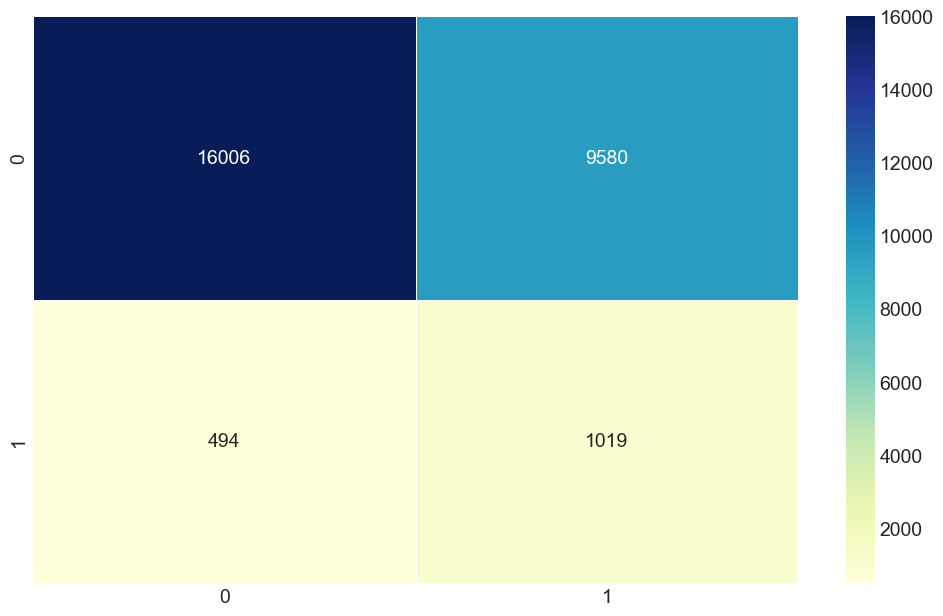

In [392]:
# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train_resampled, train_rfr_y_predictions), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, rfr_y_predictions), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, rfr_y_predictions))
print("--------"*10)



# Evaluate the model with a confusion matrix
cm_test = confusion_matrix(y_test, rfr_y_predictions)
sns.heatmap(cm_test, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

# Trying isolation forest

* this will check for anomalies in an unsupervised manner

In [393]:
from sklearn.ensemble import IsolationForest

# Assume X_train is your feature set without the label column
iso_forest = IsolationForest(n_estimators=100, contamination=0.056, random_state=42) # target is 5.6 %
iso_forest.fit(X_train)

# Predict: -1 means anomaly, 1 means normal
y_pred_isoforest = iso_forest.predict(X_test)

# Optional: convert to 0 (non-fraud) and 1 (fraud)
y_pred_binary = [1 if x == -1 else 0 for x in y_pred_isoforest]

In [394]:
y_pred_train_isoforest = iso_forest.predict(X_train)

y_pred_train_binary = [1 if x == -1 else 0 for x in y_pred_train_isoforest]

Accuracy on train set: 0.9
Accuracy on test set: 0.9
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95     25586
         1.0       0.09      0.09      0.09      1513

    accuracy                           0.90     27099
   macro avg       0.52      0.52      0.52     27099
weighted avg       0.90      0.90      0.90     27099

--------------------------------------------------------------------------------


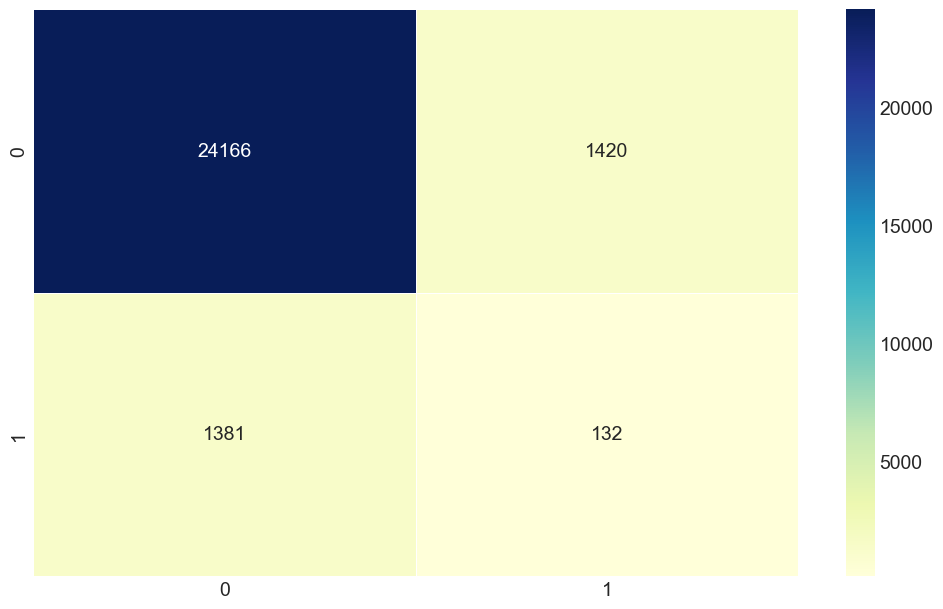

In [395]:
# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train_binary), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_binary), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred_binary))
print("--------"*10)



# Evaluate the model with a confusion matrix
cm_test = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm_test, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);